In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import torchvision.transforms as transforms
import csv
import os
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [2]:
labels = pd.read_csv('labels.csv')

In [32]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('gpu')

In [4]:
class TrainvalImageDataset(torch.utils.data.Dataset):
    
    def __init__(self, root, image_dirname, labels, transform=None):
        super().__init__()
        self.root = root
        self.image_dirname = image_dirname

        self.transform = transform
        if self.transform is None:
            self.transform = transforms.Compose([
                torchvision.transforms.ToTensor()])

        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        label, filename = self.labels.iloc[item]['Category'], self.labels.iloc[item]['Id']
        image = Image.open(os.path.join(self.root, self.image_dirname, filename)).convert('RGB')
        image = self.transform(image)

        return image, label

In [5]:
# dataset = TrainvalImageDataset('', 'trainval', labels)
# loader = torch.utils.data.DataLoader(dataset, shuffle=False)
# mean = torch.zeros(3)
# std = torch.zeros(3)
# for inputs, _ in tqdm(loader):
#     for i in range(3):
#         mean[i] += inputs[:,i,:,:].mean()
#         std[i] += inputs[:,i,:,:].std()
# mean.div_(len(dataset))
# std.div_(len(dataset))

In [6]:
mean = (0.5691, 0.5447, 0.4933)
std = (0.1883, 0.1866, 0.1916)

In [7]:
train_transform = transforms.Compose([
    transforms.RandomChoice([transforms.RandomHorizontalFlip(0.5), transforms.RandomVerticalFlip(0.5)], p=[0.5, 0.5]),
    transforms.RandomGrayscale(p=0.5),
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=5)], p=0.5),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean, std),
    torchvision.transforms.RandomErasing(scale=(0.1, 0.25), ratio=(1.0, 1.0)),
])
test_transform = transforms.Compose([
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
train, val = torch.utils.data.random_split(range(len(labels)), [1 - 0.01, 0.01], torch.Generator().manual_seed(42))
train_split = TrainvalImageDataset('', 'trainval', labels.iloc[train.indices], transform=train_transform)
val_split = TrainvalImageDataset('', 'trainval', labels.iloc[val.indices], transform=test_transform)
train_loader = torch.utils.data.DataLoader(train_split, batch_size=200, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_split, batch_size=200, shuffle=False)

In [7]:
class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32)
        )
        self.block2 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)
        self.block3 = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=8)
        )
        self.block4 = nn.Linear(in_features=800, out_features=200)

    def forward(self, x):
        out = self.block3(self.block1(x) + self.block2(x))
        out = torch.flatten(out, start_dim=1)
        out = self.block4(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, downsample=None, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.downsample = downsample
        self.stride = stride
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))

        x = self.relu(self.batch_norm2(self.conv2(x)))

        x = self.conv3(x)
        x = self.batch_norm3(x)

        if self.downsample is not None:
            identity = self.downsample(identity)
        x += identity
        x = self.relu(x)

        return x


class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=4, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout2d(0.8, inplace=True)
        self.fc = nn.Linear(512 * ResBlock.expansion, num_classes)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        downsample = None
        layers = []

        if stride != 1 or self.in_channels != planes * ResBlock.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes * ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes * ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, planes, downsample=downsample, stride=stride))
        self.in_channels = planes * ResBlock.expansion

        for _ in range(blocks - 1):
            layers.append(ResBlock(self.in_channels, planes))

        return nn.Sequential(*layers)


def resnet(num_classes):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes, 3)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [10]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy


def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step(test_loss)

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)
        print()
        print(f"Epoch {epoch}")
        print(f" train loss: {train_loss}, train acc: {train_accuracy}")
        print(f" val loss: {test_loss}, val acc: {test_accuracy}")
        print()

    return train_losses, test_losses, train_accuracies, test_accuracies

In [11]:
# model = BasicBlockNet().to(device)
model = resnet(200).to(device)
num_epochs = 100
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, cooldown=1, patience=7)

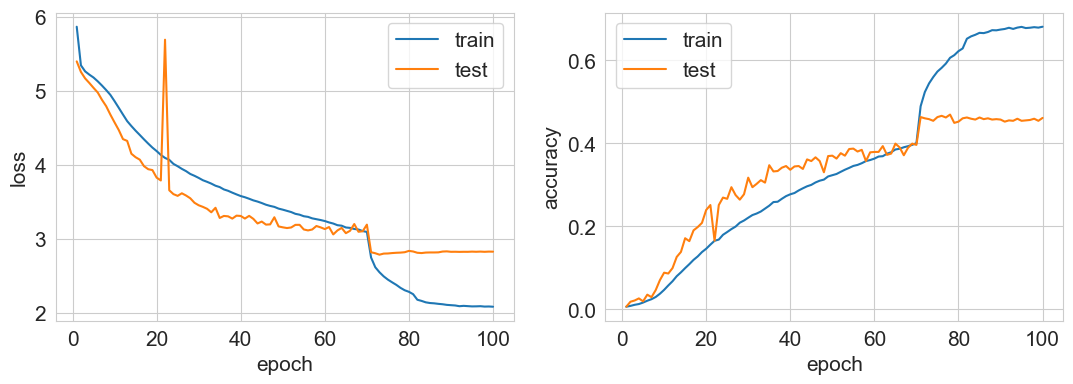


Epoch 100
 train loss: 2.085809830463294, train acc: 0.6807373737373738
 val loss: 2.8286169528961183, val acc: 0.461



In [12]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs
)

In [13]:
torch.save(model.state_dict(), 'model_state_dict.pt')

In [14]:
torch.save(model, 'full_model.pt')

In [23]:
test_classes = []

test_transform = transforms.Compose([
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

for file in os.listdir('test'):
    image = Image.open(f'test/{file}').convert('RGB')
    input = test_transform(image).unsqueeze(0).to(device)
    logits = model(input)
    test_classes.append({'Id': file, 'Category': logits.argmax(dim=1).item()})

with open('labels_test.csv', 'w', newline='') as f:
    dict_writer = csv.DictWriter(f, ('Id', 'Category'))
    dict_writer.writeheader()
    dict_writer.writerows(test_classes)

In [20]:
model = torch.load('full_model.pt')

In [21]:
train_transform_2 = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandAugment(),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean, std),
    torchvision.transforms.RandomErasing(scale=(0.1, 0.25), ratio=(1.0, 1.0)),
])
test_transform = transforms.Compose([
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
train, val = torch.utils.data.random_split(range(len(labels)), [1 - 0.01, 0.01], torch.Generator().manual_seed(42))
train_split = TrainvalImageDataset('', 'trainval', labels.iloc[train.indices], transform=train_transform_2)
val_split = TrainvalImageDataset('', 'trainval', labels.iloc[val.indices], transform=test_transform)
train_loader = torch.utils.data.DataLoader(train_split, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_split, batch_size=100, shuffle=False)

In [22]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy


def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step(test_loss)

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)
        print()
        print(f"Epoch {epoch}")
        print(f" train loss: {train_loss}, train acc: {train_accuracy}")
        print(f" val loss: {test_loss}, val acc: {test_accuracy}")
        print()

    return train_losses, test_losses, train_accuracies, test_accuracies

In [23]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, cooldown=1, patience=6)
num_epochs = 50

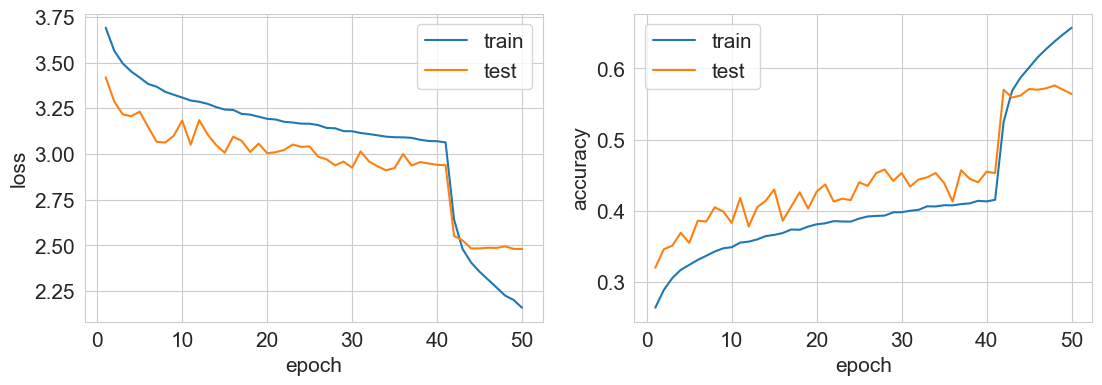


Epoch 50
 train loss: 2.159738967153761, train acc: 0.657080808080808
 val loss: 2.480769634246826, val acc: 0.564



In [24]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs
)

In [25]:
torch.save(model.state_dict(), 'model_state_dict.pt')

In [26]:
torch.save(model, 'full_model.pt')

In [27]:
test_classes = []

test_transform = transforms.Compose([
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

for file in os.listdir('test'):
    image = Image.open(f'test/{file}').convert('RGB')
    input = test_transform(image).unsqueeze(0).to(device)
    logits = model(input)
    test_classes.append({'Id': file, 'Category': logits.argmax(dim=1).item()})

with open('labels_test.csv', 'w', newline='') as f:
    dict_writer = csv.DictWriter(f, ('Id', 'Category'))
    dict_writer.writeheader()
    dict_writer.writerows(test_classes)